[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KitchinHUB/si-dynamic-catalysis-1/blob/master/Others/12-Double_Gaussian_pulse_analysis.ipynb)

# Notebook #12: Analysis of Double Gaussian pulses as forcing signal

This Jupyter Notebook is part of the Supporting Information for the paper *Cyclic steady state simulation and waveform design for Dynamic/Programmable Catalysis*, by C. C. Tedesco, J. R. Kitchin, and C. D. Laird.

In this notebook, we use a sum of two Gaussian pulses as forcing function to simulate a dynamic catalytic system. The goal is to understand the responses achieved by using separated or overlapped pulses, and different input conditions. Importantly, if the two pulses overlap, the amplitude of the individual pulses is scaled in a way that the final amplitude (of overlapped pulses) is the maximum allowed. We established 0.4 eV as the maximum reachable amplitude in our general A to B system. This notebook provides **Figure 8b and c** of the paper.

## Install Pyomo and IPOPT on Google Colab

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

!pip install munch 

## Importing necessary libraries from Python and Pyomo

In [2]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param,
                           SolverFactory, value, sin, cos, Set, exp,
                           TransformationFactory, assert_optimal_termination, RangeSet)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd
from scipy import signal
from tqdm import tqdm 
from itertools import combinations
import idaes
from scipy.optimize import minimize
import time
import pandas as pd

## Declaring parameter values

In [3]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """
    
    def __init__(self,  T = 423.15, # K
                        q = 0.0008333, # L/s
                        Po = 1.01325, # bar
                        Rg_constants = 0.0083144626, # kJ/K-gmol
                        Rg_Caf = 0.083144626, # bar-L/K-gmol
                        Rg_ODEs = 0.083144626, # bar-L/K-gmol
                        kB = 1.380649e-23, # J/K
                        hp = 6.62607015e-34, # J-s
                        F = 96.485, # mC/gmol
                        alpha = 0.6, 
                        beta = 100,
                        gamma = 2, 
                        delta = 1.4, # eV
                        H1 = 0, # kJ/mol
                        H2 = 0, # kJ/mol
                        N = 2.76e-6, # gmol sites
                        V = 2.60e-4, # L
                        Caf = 2.8423101747069843, # mol/L
                        Cbf = 0, # mol/L
                        delS1 = -135, # J/mol-K
                        delS2 = 0, # J/mol-K
                        delS3 = 135, # J/mol-K
                        number_periods = 1,
                        nfe = 900
                        ):
        
        
        self.T = T # Temperature on the simulated CSTR
        self.Po = Po # Standard pressure
        self.Caf = Caf # Initial concentration of A
        self.Cbf = Cbf # Initial concentration of B
        self.Rg_constants  = Rg_constants # Gas constant used in kinetic constants calculation
        self.Rg_Caf = Rg_Caf # Gas constant used to calculate Caf
        self.Rg_ODEs = Rg_ODEs # Gas constant used in the ODEs
        self.kB = kB # Boltzmann constant
        self.hp = hp # Plank constant
        self.F = F  # Faraday constant, for unit conversion
        self.alpha = alpha # Parameter for the BEP relation, slope of line of the relashionship
        self.beta = beta # Parameter for the BEP relation, intercept of line of the relashionship
        self.gamma = gamma # Parameter for the BE relation, slope of line of the relashionship
        self.delta = delta # Parameter for the BE relation, common BE point
        self.H1 = H1 # Enthalpy of A
        self.H2 = H2 # Enthalpy of B
        self.V = V # Volume of the CSTR
        self.delS1 = delS1 # Entropy of A
        self.delS2 = delS2 # Entropy of reaction
        self.delS3 = delS3 # Entropy of B
        self.q = q # Volumetric rate of the reactor
        self.N = N # Number of active sites on the surface
        self.number_periods = number_periods # Number of periods to be simulated 
        self.nfe = nfe # Number of discretization points

## Calculate the periodic rate constants from the forcing signal for binding energies 

In [4]:
def time_dependent_params(params, t):
    """
    Calculation of the rate constants, which are time dependent.
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        t: array of time points, discretized according to established method and parameters.

    Returns:
        Rate constant and binding energy of A values for each time point.
    """
    
    T = params.T
    Rg_constants = params.Rg_constants
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    freq_osci = params.freq_osci
    amplitude = params.amplitude
    offset = params.offset
    pulse_position1 = params.pulse_position1
    pulse_position2 = params.pulse_position2
    center_freq1 = params.center_freq1
    center_freq2 = params.center_freq2  
    number_periods = params.number_periods

    # Initiate arrays
    sum_of_gaussians = []
    gaussian_for_sum_1 = []
    gaussian_for_sum_2 = []
    gaussian1 = []
    gaussian2 = []

    # If simulating more than one period
    if number_periods > 1:
        # Position the pulses according to the positions given, depending on the period
        # Starting in 0 makes the first pulse to be in the positions stated 
        for i in range(0, number_periods):
            pulse_position_1i = pulse_position1 + i*1/freq_osci
            pulse_position_2i = pulse_position2 + i*1/freq_osci
            # Using the same center-frequency (width) for both pulses
            gaussian_1 = -2 * amplitude * np.exp(-((t - pulse_position_1i) ** 2) / ((2 * center_freq1) ** 2))
            gaussian_2 = -2 * amplitude * np.exp(-((t - pulse_position_2i) ** 2) / ((2 * center_freq2) ** 2)) 
            
            
            # Append the arrays for both pulses
            # These arrays will have number_periods + 1 rows
            # If number_periods = 2, the range is 0, 1, 2, so 3 rows
            gaussian_for_sum_1.append(gaussian_1)
            gaussian_for_sum_2.append(gaussian_2)
            
        # To be able to summ up the gaussians, we need to sum the elements in the rows
        sum_of_gaussians = (np.sum(gaussian_for_sum_1, axis=0) + np.sum(gaussian_for_sum_2, axis=0) + offset)

    else:
        gaussian1 = -2 * amplitude * np.exp(-((t - pulse_position1) ** 2) / ((2 * center_freq1) ** 2)) 
        gaussian2 = -2 * amplitude * np.exp(-((t - pulse_position2) ** 2) / ((2 * center_freq2) ** 2)) 

        sum_of_gaussians = gaussian1 + gaussian2 + offset

    # Binding energy (eV)- oscillates with a periodic gaussian pulse
    BEa = sum_of_gaussians

    # Binding energies (eV)- these values oscilate    
    BEb = gamma*BEa + H2/F - gamma*H1/F + (1 - gamma)*delta

    # Heat of reaction (kJ/mol)
    delH1 = -BEa*F # A(g) + * <--> A*
    delH2 = (H2 - BEb*F) - (H1 - BEa*F) # A* <--> B*
    delH3 = BEb*F # B* <--> B(g) + *

    # Activation energy (kJ/mol)
    Ea = alpha*delH2 + beta

    # Gibbs free energy of reaction 
    delG1 = delH1 - T*delS1*0.001
    delG2 = delH2 - T*delS2*0.001
    delG3 = delH3 - T*delS3*0.001

    # Equilibrium constants (unitless)
    K1 = np.exp(-delG1/Rg_constants/T);
    K2 = np.exp(-delG2/Rg_constants/T); 
    K3 = np.exp(-delG3/Rg_constants/T); 

    # Kinetic constants for each reaction
    kf1 = ((kB*T)/hp)*np.exp(delS1*0.001/Rg_constants) # A(g) + * --> A*
    kf2 = ((kB*T)/hp)*np.exp(-Ea/Rg_constants/T) # A* --> B*
    kr3 = ((kB*T)/hp)*np.exp(-delS3*0.001/Rg_constants) # B(g) + * --> B* 
    kr1 = kf1/K1 # A* --> A(g) + *
    kr2 = kf2/K2 # B* --> A*
    kf3 = kr3*K3 # B* --> B(g) + *

    return Munch(kf1=kf1, kf2=kf2, kf3=kf3, kr1=kr1, kr2=kr2, kr3=kr3, BEa=BEa)

## Create the Pyomo model

In [5]:
def create_pyomo_model(params):
    T = params.T
    q = params.q
    Po = params.Po
    Caf = params.Caf
    Cbf = params.Cbf
    Rg_constants = params.Rg_constants
    Rg_Caf = params.Rg_Caf
    Rg_ODEs = params.Rg_ODEs
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    amplitude = params.amplitude
    N = params.N
    V = params.V
    offset = params.offset
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    freq_osci = params.freq_osci
    number_periods = params.number_periods
    
    # Declare pyomo model, parameters and time span
    m = ConcreteModel()
    m.params = params
    
    
    m.tau = ContinuousSet(bounds=(0, 1)) # Unscaled time
    m.times = Var(m.tau) # not a continuous set, but a variable that depends on tau
    m.tf = Param(initialize = params.number_periods*1/params.freq_osci)
    
    # Define variables- concentrations varying with time, 
    # initialized in values that would make sense to be the solution
    m.Ca = Var(m.tau, initialize=2.84)
    m.Cb = Var(m.tau, initialize=0.1)
    m.thetaA = Var(m.tau, initialize=0.5)
    m.thetaB = Var(m.tau, initialize=0.5)

    # Declare derivative variables
    m.dtimedtau = DerivativeVar(m.times)
    m.dCadt = DerivativeVar(m.Ca)
    m.dCbdt = DerivativeVar(m.Cb)
    m.dthetaAdt = DerivativeVar(m.thetaA)
    m.dthetaBdt = DerivativeVar(m.thetaB)
    

    @m.Constraint(m.tau)
    def _ode3(m,t):
        if t == 0:
            return Constraint.Skip
        return m.dtimedtau[t] == m.tf
    
    
    # Declare ODEs as contraints
    
    # Constraint that depends on time span
    @m.Constraint(m.tau)
    # Define equation that is a function of the model and t
    def dCadt_eq(m,t):
        # pt gets the result of the function 
        pt = time_dependent_params(m.params, t)
        # Declare theta_star since it varies with thetaA and B and therefore, with time
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        # ODE, being that `munch` format was used to get the k's from the function
        return m.dCadt[t] == m.tf * ((q/V)*(Caf - m.Ca[t]) \
            - pt.kf1*m.Ca[t]*Rg_ODEs*T*(theta_star)/Po*(N/V) + pt.kr1*m.thetaA[t]*(N/V))

    @m.Constraint(m.tau)
    def dCbdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dCbdt[t] == m.tf * ((q/V)*(Cbf - m.Cb[t]) \
            + (pt.kf3*m.thetaB[t] - pt.kr3*m.Cb[t]*Rg_ODEs*T*(theta_star)/Po)*(N/V))

    @m.Constraint(m.tau)
    def dthetaAdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return  m.dthetaAdt[t] == m.tf * (pt.kf1*m.Ca[t]*Rg_ODEs*T*(theta_star)/Po \
            - pt.kr1*m.thetaA[t] - pt.kf2*m.thetaA[t] + pt.kr2*m.thetaB[t])
    
    @m.Constraint(m.tau)
    def dthetaBdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dthetaBdt[t] == m.tf * ((pt.kf2*m.thetaA[t] - pt.kr2*m.thetaB[t]) \
            - (pt.kf3*m.thetaB[t] - pt.kr3*m.Cb[t]*Rg_ODEs*T*(theta_star)/Po))

    
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m,nfe=900,scheme='BACKWARD')
    
    # Return the model
    return m

## Solving the model and calculating avTOF from the results

In [6]:
def tof_from_decision_vars(params, tee=True):
    """
    Solves the Pyomo model and calculates avTOF from results of solving the BVP
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tee = True: Returns the ipopt log, which is advised. Use Tee = False in case you do not want to see the log.

    Returns:
        Value of the time-averaged turnover frequency
    """
        
    # Get the Pyomo model with final time as the number of periods times the period of the forcing wave
    m = create_pyomo_model(params)
    
    # Key part of the approach!
    # Equality constraints for initial and final points - to guarantee periodicity 
    # and simulation of full cycles
    m.CaCSS = Constraint(expr= m.Ca[m.tau.first()] == m.Ca[m.tau.last()])
    m.CbCSS = Constraint(expr= m.Cb[m.tau.first()] == m.Cb[m.tau.last()])
    m.thetaACSS = Constraint(expr= m.thetaA[m.tau.first()] == m.thetaA[m.tau.last()])
    m.thetaBCSS = Constraint(expr= m.thetaB[m.tau.first()] == m.thetaB[m.tau.last()])

    # Call ipopt as solver on the square problem/ simulation
    solver = SolverFactory('ipopt')
    # If solving in a loop, terminate runs when unable to solve
    status = solver.solve(m, tee=tee)
    assert_optimal_termination(status)


    # Attributing arrays for calculating plotting
    Ca = [value(m.Ca[t]) for t in m.tau]
    Cb = np.asarray([value(m.Cb[t]) for t in m.tau])
    thetaA = [value(m.thetaA[t]) for t in m.tau]
    thetaB = [value(m.thetaB[t]) for t in m.tau]
    theta_star = [value(1 - m.thetaA[t] - m.thetaB[t]) for t in m.tau]

    # Calculating TOF from the concentration of product desorbed
    TOF = Cb*params.q/params.N
    
    m.real_time = ContinuousSet(initialize=[0, params.number_periods*1/params.freq_osci])
    
    # Calculating the time-average by integration with the trapezoid method
    avTOF = np.trapz(TOF/(1), m.tau) 
    return [TOF, avTOF]

In [7]:
def min_BE_value(amplitude, frequency, center_freq1, center_freq2, pulse_position1, pulse_position2, offset):
    """
    Builds the array of BEa values and identifies the lower value, 
    for verification of higher amplitude due to overlapping of pulses
    """
    
    t = np.linspace(0, 1 / frequency, 1000)
    
    gaussian1 = -2 * amplitude * np.exp(-((t - pulse_position1) ** 2) / ((2 * center_freq1) ** 2))
    gaussian2 = -2 * amplitude * np.exp(-((t - pulse_position2) ** 2) / ((2 * center_freq2) ** 2))
    
    sum_of_gaussians = gaussian1 + gaussian2 + offset
    min_BE = np.min(sum_of_gaussians)
    
    return min_BE

In [8]:
def objective_function(amplitude, target_min_value, center_freq1, center_freq2, pulse_position1, pulse_position2, offset):
    """
    In case the pulses overlapse and the final amplitude is higher than the maximum accepted,
    this objective function is used to find what should be the value of the amplitude of individual pulses.
    """
    
    min_BE = min_BE_value(amplitude, frequency, center_freq1, center_freq2, pulse_position1, pulse_position2, offset)
    
    # Objective is to minimize the sum of square errors between the minimum value obtained and the desired 
    # one, with amplitude of individual pulses as decision variable
    obj_function = np.sum((target_min_value - min_BE) ** 2)
    
    return obj_function

## System with frequency = 1000 Hz

### Oscillation and Gaussian pulses parameters

In [9]:
params = Params()

params.freq_osci = 1000

params.amplitude = 0.4
params.offset = 1.78

# Same width for both pulses
params.center_freq1 = 0.034
params.center_freq2 = 0.034

# Fix the position of one pulse
params.pulse_position1 = 0.75

# Determine the position of the second pulse
# for pulse position 2 = 0.25 pulses will be separated, for 0.85 they will overlap
pulse_positions2 = [0.25, 0.85]

### Simulation for separated and overlapping pulses 

For the second pulse positioned in 0.25, avTOF = 796.92 Hz
For the second pulse positioned in 0.85, avTOF = 745.44 Hz


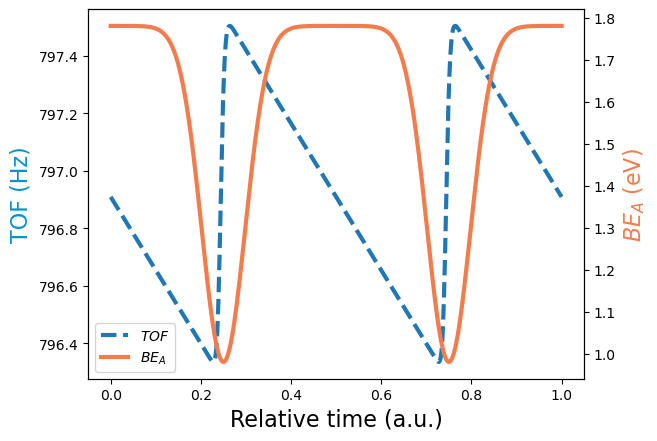

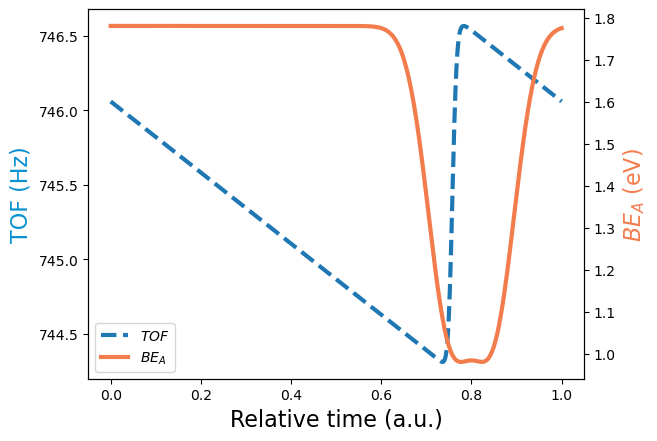

In [10]:
for params.pulse_position2 in pulse_positions2:
    
    TOF, avTOF = tof_from_decision_vars(params, tee = False)

    # Returning the model to be able to get BE of A values
    m = create_pyomo_model(params)

    # Getting BE of A values for plotting
    def be(m,t):
        pt = time_dependent_params(params, t)  
        Be_a = pt.BEa
        return Be_a

    BEa_array = []
    for t in m.times:
        bea = be(m, t)
        BEa_array.append(bea)

    min_BE_original = np.min(BEa_array)
    target_min_value = params.offset - 2 * params.amplitude

    # Pulses overlap is identify if the lower BE value is smaller than the targetted
    if  min_BE_original < target_min_value:
        
        frequency = 1 # since time is normalized
        amplitude = params.amplitude
        center_freq1 = params.center_freq1
        center_freq2 = params.center_freq2
        pulse_position1 = params.pulse_position1
        pulse_position2 = params.pulse_position2
        offset = params.offset

        initial_guess = 0.3

        sol = minimize(objective_function, initial_guess, args=(target_min_value, center_freq1, center_freq2, pulse_position1, pulse_position2, offset))
        new_amplitude = sol.x

        # Simulate the system using the identified amplitude that leads to global max amplitude 
        params.amplitude = new_amplitude
        TOF, avTOF = tof_from_decision_vars(params, tee = False)
        print(f'For the second pulse positioned in {params.pulse_position2}, avTOF = {avTOF:1.2f} Hz')

        # Returning the model to be able to get BE of A values
        m = create_pyomo_model(params)

        # Getting BE of A values for plotting
        def be(m,t):
            pt = time_dependent_params(params, t)  
            Be_a = pt.BEa
            return Be_a

        BEa_array = []
        for t in m.times:
            bea = be(m, t)
            BEa_array.append(bea)

        # Creating the two plots in the same frame
        fig, ax1 = plt.subplots()

        # Creating the first plot: times x TOF plot
        ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle='--')
        ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
        ax1.set_xlabel('Relative time (a.u.)', fontsize=16)

        # Creating the second plot: times x BEa with axes on the right side
        ax2 = ax1.twinx()
        ax2.plot(m.tau, BEa_array, label='$BE_A$', color='#f37c4c', linewidth=3)
        ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower left');
    
    else:
        print(f'For the second pulse positioned in {params.pulse_position2}, avTOF = {avTOF:1.2f} Hz')
        
        # Returning the model to be able to get BE of A values
        m = create_pyomo_model(params)

        # Getting BE of A values for plotting
        def be(m,t):
            pt = time_dependent_params(params, t)  
            Be_a = pt.BEa
            return Be_a

        BEa_array = []
        for t in m.times:
            bea = be(m, t)
            BEa_array.append(bea)

        # Creating the two plots in the same frame
        fig, ax1 = plt.subplots()

        # Creating the first plot: times x TOF plot
        ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle='--')
        ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
        ax1.set_xlabel('Relative time (a.u.)', fontsize=16)

        # Creating the second plot: times x BEa with axes on the right side
        ax2 = ax1.twinx()
        ax2.plot(m.tau, BEa_array, label='$BE_A$', color='#f37c4c', linewidth=3)
        ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower left');

We can see that for the system in which frequency = 1000 Hz, using separate pulses leads to a higher value of avTOF. This is because the double pulse works as doubling the frequency.

## System with frequency = 1300 Hz

### Oscillation and Gaussian pulses parameters

In [11]:
params = Params()

params.freq_osci = 1300

params.amplitude = 0.4
params.offset = 1.78

# Same width for both pulses
params.center_freq1 = 0.034
params.center_freq2 = 0.034

# Fix the position of one pulse
params.pulse_position1 = 0.75

# Determine the position of the second pulse
# for pulse position 2 = 0.25 pulses will be separated, for 0.85 they will overlap
pulse_positions2 = [0.25, 0.85]

### Simulation for separated and overlapping pulses 

For the second pulse positioned in 0.25, avTOF = 806.58 Hz
For the second pulse positioned in 0.85, avTOF = 828.81 Hz


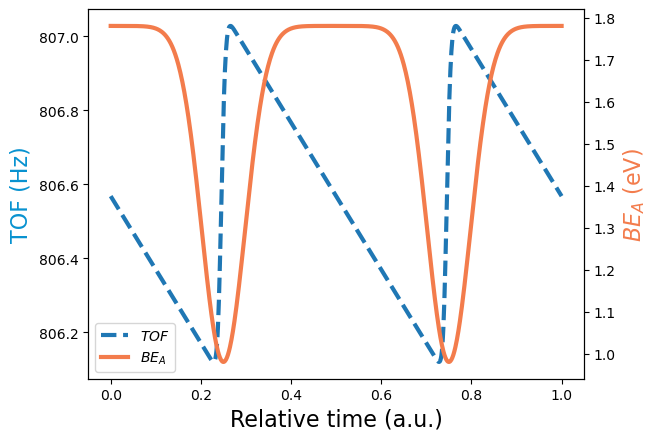

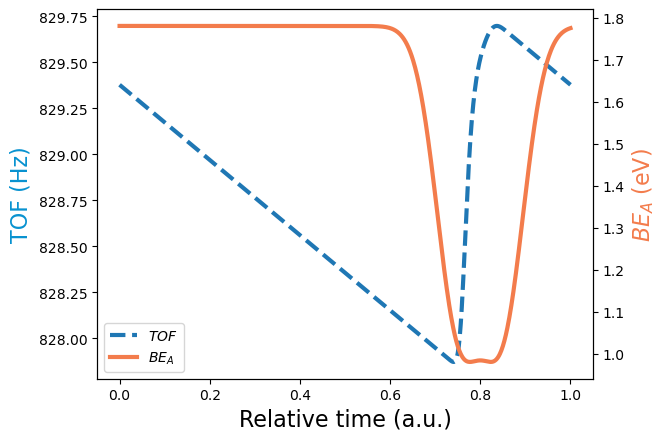

In [12]:
for params.pulse_position2 in pulse_positions2:
    
    TOF, avTOF = tof_from_decision_vars(params, tee = False)

    # Returning the model to be able to get BE of A values
    m = create_pyomo_model(params)

    # Getting BE of A values for plotting
    def be(m,t):
        pt = time_dependent_params(params, t)  
        Be_a = pt.BEa
        return Be_a

    BEa_array = []
    for t in m.times:
        bea = be(m, t)
        BEa_array.append(bea)

    min_BE_original = np.min(BEa_array)
    target_min_value = params.offset - 2 * params.amplitude

    # Pulses overlap is identify if the lower BE value is smaller than the targetted
    if  min_BE_original < target_min_value:
        
        frequency = 1 # since time is normalized
        amplitude = params.amplitude
        center_freq1 = params.center_freq1
        center_freq2 = params.center_freq2
        pulse_position1 = params.pulse_position1
        pulse_position2 = params.pulse_position2
        offset = params.offset

        initial_guess = 0.3

        sol = minimize(objective_function, initial_guess, args=(target_min_value, center_freq1, center_freq2, pulse_position1, pulse_position2, offset))
        new_amplitude = sol.x

        # Simulate the system using the identified amplitude that leads to global max amplitude 
        params.amplitude = new_amplitude
        TOF, avTOF = tof_from_decision_vars(params, tee = False)
        print(f'For the second pulse positioned in {params.pulse_position2}, avTOF = {avTOF:1.2f} Hz')

        # Returning the model to be able to get BE of A values
        m = create_pyomo_model(params)

        # Getting BE of A values for plotting
        def be(m,t):
            pt = time_dependent_params(params, t)  
            Be_a = pt.BEa
            return Be_a

        BEa_array = []
        for t in m.times:
            bea = be(m, t)
            BEa_array.append(bea)

        # Creating the two plots in the same frame
        fig, ax1 = plt.subplots()

        # Creating the first plot: times x TOF plot
        ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle='--')
        ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
        ax1.set_xlabel('Relative time (a.u.)', fontsize=16)

        # Creating the second plot: times x BEa with axes on the right side
        ax2 = ax1.twinx()
        ax2.plot(m.tau, BEa_array, label='$BE_A$', color='#f37c4c', linewidth=3)
        ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower left');
    
    else:
        print(f'For the second pulse positioned in {params.pulse_position2}, avTOF = {avTOF:1.2f} Hz')
        
        # Returning the model to be able to get BE of A values
        m = create_pyomo_model(params)

        # Getting BE of A values for plotting
        def be(m,t):
            pt = time_dependent_params(params, t)  
            Be_a = pt.BEa
            return Be_a

        BEa_array = []
        for t in m.times:
            bea = be(m, t)
            BEa_array.append(bea)

        # Creating the two plots in the same frame
        fig, ax1 = plt.subplots()

        # Creating the first plot: times x TOF plot
        ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle='--')
        ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
        ax1.set_xlabel('Relative time (a.u.)', fontsize=16)

        # Creating the second plot: times x BEa with axes on the right side
        ax2 = ax1.twinx()
        ax2.plot(m.tau, BEa_array, label='$BE_A$', color='#f37c4c', linewidth=3)
        ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower left');

We can see that for the system in which frequency = 1300 Hz, using separate pulses leads to a lower value of avTOF. This is because the frequency of 1300 Hz is already on or closer to the frequency band in which avTOF changes gets small. Therefore, doubling this value will not be more productive then overlapping the pulses in a way that they end up resembling the optimized square wave, with apparently more abrupt changes between extreme BE value and more time spent in the lower BE state.